In [1]:
import json

import nibabel as nib
import sys

import scipy.ndimage
from matplotlib import pyplot as plt
sys.path.append('bin')
import bin.analysis as analysis
import bin.representation_geometry as geo
import numpy
import numpy as np
import torch
from torch import nn
import pandas as pd
import networkx as nx
import graspologic as gr
from bin.graphIO import GraphIO
from sklearn.tree import DecisionTreeClassifier, plot_tree

from neurotools import modules

Intel Hardware Acceleration is not enabled. 


/home/ssbeast/Projects/nilearn/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/ssbeast/Projects/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
atlas_nii = nib.load("/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/pollux/templates/combined_atlas.nii")
atlas = torch.round(torch.from_numpy(atlas_nii.get_fdata())).int()
lookup = pd.read_csv("/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/pollux/templates/atlas_lookup.txt", header=0, index_col=0, delimiter='\t')


In [3]:
# grab the shape color beta matrix for pollux
beta = '/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/pollux/analysis/curated_betas.nii.gz'
beta_nii = nib.load(beta)
affine = beta_nii.affine
header = beta_nii.header
beta = np.array(beta_nii.get_fdata())
flat_beta = torch.from_numpy(beta)[(atlas > 0)]
flat_beta = flat_beta - flat_beta.mean(axis=1).unsqueeze(1)

# grab the shape color beta matrix for castor
beta = '/home/ssbeast/Projects/SS/monkey_fmri/CCSF/subjects/castor/analysis/reg_curated_betas.nii.gz'
beta_nii = nib.load(beta)
affine2 = beta_nii.affine
header2 = beta_nii.header
beta = np.array(beta_nii.get_fdata())
flat_beta2 = torch.from_numpy(beta)[(atlas > 0)]
flat_beta2 = flat_beta2 - flat_beta2.mean(axis=1).unsqueeze(1)


# construct the curated betas
flat_beta = (flat_beta + flat_beta2) / 2

aday = flat_beta[:, 2]
high_minus_low_sat = (flat_beta[:, 4] - flat_beta[:, 5]) + (flat_beta[:, 6] - flat_beta[:, 7])
high_minus_low_sat = (high_minus_low_sat - high_minus_low_sat.mean()) / high_minus_low_sat.std()
h_m_l_freq = (flat_beta[:, -2] - flat_beta[:, -1])
flat_beta = torch.stack([aday, high_minus_low_sat,  h_m_l_freq], dim=1)
flat_beta = (flat_beta - flat_beta.mean(dim=0)) / flat_beta.std(dim=0)


In [4]:
np_beta = np.array(flat_beta)

In [5]:
brain_mask_nii = nib.load('/home/ssbeast/LSR_DS4/bc7/projects/CCSF/CCSF/subjects/pollux/mri/ds_brain.nii')
brain_mask = torch.from_numpy(np.array(brain_mask_nii.get_fdata().astype(bool)))

In [6]:

atlas_idxs = sorted(torch.unique(atlas).tolist())[1:]

In [7]:
import math

beta_mag = torch.std(flat_beta, dim=1)
cutoff = math.ceil(1. * len(beta_mag))
_, sort_idxs = torch.sort(beta_mag, descending=False)
to_use = sort_idxs[:cutoff]
flat_beta = flat_beta[to_use]




In [8]:
# feature_names = ["Black White high 0.2 cycles per degree",
#                 "Black White high 4.0 cycles per degree",
#                 "Black White high 8.0 cycles per degree",
#                 "Black White low 0.2 cycles per degree",
#                 "Black White low 4.0 cycles per degree",
#                 "Black White low 8.0 cycles per degree",
#                 "Blue Yellow 0.2 cycles per degree",
#                 "Blue Yellow 4.0 cycles per degree",
#                 "Blue Yellow 8.0 cycles per degree",
#                 "Red Green 0.2 cycles per degree",
#                 "Red Green 4.0 cycles per degree",
#                 "Red Green 8.0 cycles per degree",
#                 "Color 1 Contrast 0.5",
#                 "Color 2 Contrast 0.3",
#                 "Color 3 Contrast 0.1",
#                 "Color 4 Contrast 0.95",
#                 "Color 5 Contrast 0.5",
#                 "Color 6 Contrast 0.3",
#                 "Color 7 Contrast 0.1",
#                 "Color 8 Contrast 0.95",
#                 "Color 9 Contrast 0.5",
#                 "Color 1 Contrast 0.3",
#                 "Color 2 Contrast 0.1",
#                 "Color 3 Contrast 0.95",
#                 "Color 4 Contrast 0.5",
#                 "Color 5 Contrast 0.3",
#                 "Color 6 Contrast 0.1",
#                 "Color 7 Contrast 0.95",
#                 "Color 8 Contrast 0.5",
#                 "Color 9 Contrast 0.3",
#                 "Color 1 Contrast 0.1",
#                 "Color 2 Contrast 0.95",
#                 "Color 3 Contrast 0.5",
#                 "Color 4 Contrast 0.3",
#                 "Color 5 Contrast 0.1",
#                 "Color 6 Contrast 0.95",
#                 "Color 7 Contrast 0.5",
#                 "Color 8 Contrast 0.3",
#                 "Color 9 Contrast 0.1",
#                 "Color 1 Contrast 0.95",
#                 "Color 2 Contrast 0.5",
#                 "Color 3 Contrast 0.3",
#                 "Color 4 Contrast 0.1",
#                 "Color 5 Contrast 0.95",
#                 "Color 6 Contrast 0.5",
#                 "Color 7 Contrast 0.3",
#                 "Color 8 Contrast 0.1",
#                 "Color 9 Contrast 0.95"]

# feature_names = ['daylight_high_sat', 'daylight_low_sat', 'antidaylight_high_sat', 'antidaylight_low_sat', 'lm_high_sat', 'lm_low_sat', 's_high_sat', 's_low_sat', 'lms_high_sat', 'lms_low_sat', 'lm_high_freq', 'lm_low_freq', 's_high_freq', 's_low_freq', 'lms_high_freq', 'lms_low_freq']
feature_names = ['antidaylight', "high_sat_color - low_sat_color", "high_freq_lms - low_freq_lms"]

In [9]:
# proj, vecs, vals = geo.pca(flat_beta, noisy=True, n_components=3)
proj = flat_beta
flat_atlas = atlas[atlas > 0]
flat_atlas = flat_atlas[to_use]

In [10]:
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r), int(g), int(b))

In [11]:
%matplotlib qt
fig = plt.figure()
ax = plt.axes(projection='3d')
# fig, ax = plt.subplots(1)
fig.set_size_inches((12, 12))
idxs = torch.randperm(proj.shape[0])[:]
proj_sample = proj[idxs, :]
cmap = plt.get_cmap('hsv')
num_rois = len(atlas_idxs)
for i, key in enumerate(atlas_idxs[:]):
    c = cmap(float(i / num_rois) * .8)
    label = lookup.loc[key]['Label Name:']
    roi_proj = proj_sample[flat_atlas[idxs]==key, :]
    mean, _ = torch.median(roi_proj, dim=0)
    ind = np.random.choice(np.arange(len(roi_proj)), 100)
    roi_proj = roi_proj[ind]
    ax.scatter(roi_proj[:, 0], roi_proj[:, 1], roi_proj[:, 2], s=10, color=c, alpha=.1)
    ax.scatter(mean[0], mean[1], mean[2], s=300, color=c, marker='o', label=label, alpha=.5)
    ax.text(mean[0], mean[1], mean[2], label)
# ax.set_ylim(-1.5, 1.5)
# ax.set_xlim(-2.5, .5)
ax.set_xlabel("antidaylight")
ax.set_ylabel("high_sat_color - low_sat_color")
ax.set_zlabel("high_freq_lms - low_freq_lms")
ax.set_facecolor('silver')
plt.legend()
plt.show()


In [12]:
print(vecs[:, 0:3].T.tolist())
print(len(vecs[1]))

NameError: name 'vecs' is not defined

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a1698f70>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

BIC for 1 components is 79072.05420338766
BIC for 2 components is 76999.66118879628


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a0fe3e50>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


BIC for 3 components is 76522.24872287406


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a0fe3e50>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


BIC for 4 components is 76595.92122675505


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a172c820>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


BIC for 5 components is 76824.31740364614


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a1698f70>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


BIC for 6 components is 76544.70786211386


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a0fe3e50>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


BIC for 7 components is 76516.41747908527
BIC for 8 components is 76518.99294600633


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a0fe3e50>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

BIC for 9 components is 76603.19963789615


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc6a0fe3e50>
Traceback (most recent call last):
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


BIC for 10 components is 76696.5713055762
BIC for 11 components is 76650.15877418756


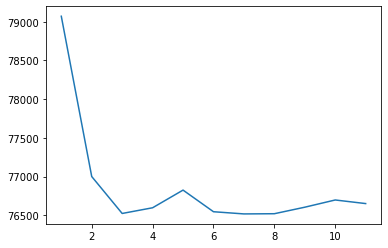

In [12]:
%matplotlib inline
from sklearn.mixture import GaussianMixture
component_min = 1
component_max = 12
bics = []
gmms = []
gmm_beta = proj.numpy()[:, :2]
for n_comp in range(component_min, component_max):
    gmm = GaussianMixture(n_components=n_comp)
    gmm.fit(gmm_beta)
    bic = gmm.bic(gmm_beta)
    print("BIC for", n_comp, "components is", bic)
    bics.append(bic)
    gmms.append(gmm)
plt.plot(range(component_min, component_max), bics)

In [13]:
best_gmm = gmms[2]
print(best_gmm.means_)

[[ 0.39208153  0.38264981]
 [ 0.42464603  0.63951107]
 [-0.69980947 -0.85445545]]


In [14]:
labels = best_gmm.predict(gmm_beta)
unique_labels = np.unique(labels)
for roi in atlas_idxs:
    roi_idxs = (flat_atlas == roi).numpy()
    roi_size = np.count_nonzero(roi_idxs)
    for label in unique_labels:
        label_idxs = (labels==label)
        truth = numpy.logical_and(roi_idxs, label_idxs)
        overlap = np.count_nonzero(truth)
        percent_label = overlap / roi_size
        print(100 * float(percent_label), "% of roi", lookup.loc[roi]['Label Name:'], "assigned to label ", int(label))

31.35593220338983 % of roi MT-rh assigned to label  0
5.084745762711865 % of roi MT-rh assigned to label  1
63.559322033898304 % of roi MT-rh assigned to label  2
62.936344969199176 % of roi V1d-lh assigned to label  0
20.32854209445585 % of roi V1d-lh assigned to label  1
16.73511293634497 % of roi V1d-lh assigned to label  2
54.93827160493827 % of roi V1d-rh assigned to label  0
23.681257014590347 % of roi V1d-rh assigned to label  1
21.38047138047138 % of roi V1d-rh assigned to label  2
50.16642891107941 % of roi V1v-lh assigned to label  0
28.38801711840228 % of roi V1v-lh assigned to label  1
21.445553970518308 % of roi V1v-lh assigned to label  2
64.60176991150442 % of roi MT-lh assigned to label  0
1.7699115044247788 % of roi MT-lh assigned to label  1
33.6283185840708 % of roi MT-lh assigned to label  2
42.53945480631277 % of roi V1v-rh assigned to label  0
33.715925394548066 % of roi V1v-rh assigned to label  1
23.74461979913917 % of roi V1v-rh assigned to label  2
33.44887348

In [64]:
print(vecs[:, :2].T.tolist())
print(len(vecs[1]))

[[-0.38561005064157294, -0.47010338882636177, -0.26875039015467816, 0.0014822511933652266, -0.08813018225317351, 0.12483115372457647, -0.3295108770325445, 0.0669690818840635, 0.17896067903070287, -0.4304551224820878, -0.05330660646343763, 1.6536234520211495, -0.016990324672428978, -0.13532620407034077, 0.44586046344854596, -0.438387069329835, -0.0018767327157176617, 0.22767182999301866, 0.22867242196554094, -0.22533069246290593, -0.22062110514918828, 0.13192255299140307, 0.646294364520961, -0.516742329891553, 0.002024148423540103, 0.14566719676979206, -0.10611755352981028, -0.12990201615521033, 0.12997527921538812, 0.5862249512697862, 0.723298370530241, -0.2534859670932472, -0.2538300129449031, 0.304470689052933, 0.6497682518944893, -0.31281250358556256, 0.16411773686004572, 0.06458775967787145, 0.6655145396073987, -0.9378166383568451, -0.4689631425821906, 0.2362931097918137, -0.0908210929243647, -0.8081591418796048, -0.6649153114735025, -0.033425564520642916, 0.4188508800193164, -0.15

In [14]:
import importlib
geo = importlib.reload(geo)
corr_adj, roi_idx, rdms, pvals = geo.pairwise_rsa(flat_beta, atlas=flat_atlas, ignore_atlas_base=False, metric='cosine')

In [15]:
roi_names = {i:lookup.loc[idx.item()]['Label Name:'] for i, idx in enumerate(roi_idx)}

In [16]:
fig, axs = plt.subplots(4, 5)
for i, rdm in enumerate(rdms):
    rdm = rdm.numpy()
    size = flat_beta.shape[1]
    rdm_mat = np.zeros((size, size))
    rdm_mat[np.triu_indices(rdm_mat.shape[0], k = 1)] = rdm
    rdm_mat = rdm_mat + rdm_mat.T
    idx = (int(np.floor(i / 5)), int(i % 5))
    axs[idx[0], idx[1]].imshow(rdm_mat, vmin=-1, vmax=1)
    axs[idx[0], idx[1]].set_title(roi_names[i])
fig.set_size_inches(16, 20)
plt.show()

In [17]:
np_adj = corr_adj.numpy()
weight_std = np.std(np_adj)
weight_mean = np.mean(np_adj)
print(weight_mean)
print(weight_std)

0.74
0.29563493


In [18]:
import networkx as nx
roi_corr_graph = nx.from_numpy_array(np_adj, create_using=nx.Graph)
# roi_atlas = roi_atlas.get_fdata()
for node in roi_corr_graph.nodes():
    roi_corr_graph.nodes[node]['roi_name'] = roi_names[node]
    roi_corr_graph.nodes[node]['rdm'] = rdms[node].tolist()
    roi_corr_graph.nodes[node]['num_dims'] = np.count_nonzero(atlas==roi_idx[node].item())

In [19]:
# from bin.graphIO import GraphIO
# for s, t, data in list(roi_corr_graph.edges(data=True)):
#     if (pvals[s, t] > .1 or np.abs(data['weight']) < .8) and np.abs(data['weight']) < .95:
#         roi_corr_graph.remove_edge(s, t)
GraphIO.dump(roi_corr_graph, "/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/0826_pollux_cor_graph_all_edge.json")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/0826_pollux_cor_graph_all_edge.json'

In [21]:
pos_graph = roi_corr_graph.copy()
for s, t, data in pos_graph.edges(data=True):
    pos_graph.edges[(s, t)]['weight'] = np.abs(data['weight'])
undirected_connectome, layout = gr.layouts.layout_tsne(pos_graph,
                                                       perplexity=100,
                                                       n_iter=100000)
for s, t, data in undirected_connectome.edges(data=True):
    undirected_connectome.edges[(s, t)]['weight'] = roi_corr_graph.edges[(s, t)]['weight']

/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ssbeast/anaconda3/envs/ssfmri/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
from graspologic.layouts.classes import NodePosition
for i in range(len(layout)):
    new_data = gr.layouts.classes.NodePosition(node_id=int(layout[i].node_id),
                                               x=layout[i].x,
                                               y=layout[i].y,
                                               size=layout[i].size,
                                               community=layout[i].community)
    layout[i] = new_data
cmap = plt.get_cmap('viridis')

raw_edge_weights = np.array([edge[2]['weight'] for edge in undirected_connectome.edges(data=True)])
edge_weights = raw_edge_weights - min(raw_edge_weights)
edge_weights = edge_weights / max(edge_weights)

edge_colors = np.array([cmap(val) for val in edge_weights])

edge_widths = np.abs(raw_edge_weights) - np.min(raw_edge_weights)
edge_widths = edge_widths / max(edge_widths)
edge_widths = (1. * edge_widths) + .25

node_colors = ['#808080'] * len(undirected_connectome.nodes())
labels = {}
for n in undirected_connectome.nodes:
    if 'roi_name' in undirected_connectome.nodes[n]:
        labels[n] = undirected_connectome.nodes[n]['roi_name']
    else:
        labels[n] = 'unnamed'

In [23]:
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r*255), int(g*255), int(b*255))

for i, edge in enumerate(undirected_connectome.edges()):
    s, t = edge
    undirected_connectome.edges[(s, t)]['color'] = rgb_to_hex(edge_colors[i][0], edge_colors[i][1], edge_colors[i][2])
    undirected_connectome.edges[(s, t)]['width'] = edge_widths[i]
for i, n in enumerate(undirected_connectome.nodes()):
    undirected_connectome.nodes[n]['graphics'] = {'x': layout[i].x,
                                                  'y': layout[i].y,
                                                  'w': layout[i].size,
                                                  'h': layout[i].size}

#nx.readwrite.write_gml(undirected_connectome, "/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/pollux_cor_graph.gml") # write to gml for loading with cytoscape

In [19]:
drawing = gr.layouts.render._draw_graph(undirected_connectome, layout, node_colors, 1.,
                                        edge_line_width=edge_widths,
                                        edge_alpha=1.,
                                        figure_width=25,
                                        figure_height=25)

Error in callback <function flush_figures at 0x7f0de5860430> (for post_execute):


KeyboardInterrupt: 

In [26]:
from graspologic.embed import AdjacencySpectralEmbed
from neurotools import modules
ase = AdjacencySpectralEmbed(n_components=2)
#roi_corr_graph.remove_node(1)
#embeddings = ase.fit_transform(roi_corr_graph)
mds = modules.MDScale(20, 2)
mask_np_adj = np_adj
mask_np_adj[np.diag_indices(len(np_adj))] = 0
dists = (np.max(mask_np_adj) - mask_np_adj)
embeddings = mds.fit_transform(torch.from_numpy(dists), max_iter=500000)

Right Initial System Tension:  0.2659470736980438
Right Final System Tension:  0.00032778785680420697


In [27]:
fig, ax = plt.subplots()
fig.set_size_inches((8, 8))

cmap = plt.get_cmap('hsv')
num_rois = len(roi_corr_graph)
for i, key in enumerate(roi_corr_graph.nodes()):
    c = cmap(float(i / num_rois))
    label = roi_names[i]
    ax.scatter(embeddings[i, 0], embeddings[i, 1], s=100, color=c, marker='o')
    ax.annotate(label, (embeddings[i, 0], embeddings[i, 1],), xytext=(0,0), textcoords='offset points')
# ax.set_ylim(-10, 10)
# ax.set_xlim(25, 125)
ax.set_facecolor('silver')
plt.show()

Spotlight RSA

In [22]:
search = geo.SearchlightDissimilarity(betas=beta, desired_kernel_size=6)

104


In [23]:
search.fit(stride=5)

In [24]:
rdms = np.array(search.rdms)

In [25]:
dist = search.predict()

KeyboardInterrupt: 

In [12]:
min(dist)

tensor(-0.5906)

In [48]:
import scipy
atlas = geo._pad_to_cube(atlas)
flat_atlas = scipy.ndimage.zoom(atlas, zoom=np.power(len(rdms), (1/3)) / len(atlas), order=0)
flat_atlas = np.round(flat_atlas.flatten()).astype(int)
loc_atlas = flat_atlas[flat_atlas > 0]

In [28]:
dist = (((dist * -1) + 1) * 10) ** 2
indices = torch.triu_indices(len(rdms), len(rdms), offset=1)
in_roi_dist = torch.zeros((len(loc_atlas) * (len(loc_atlas) - 1) / 2,) )


In [29]:

mds = modules.MDScale(len(rdms), embed_dims=2, device='cuda')

In [30]:
mds.fit(dist)

In [31]:
embed = mds.predict()

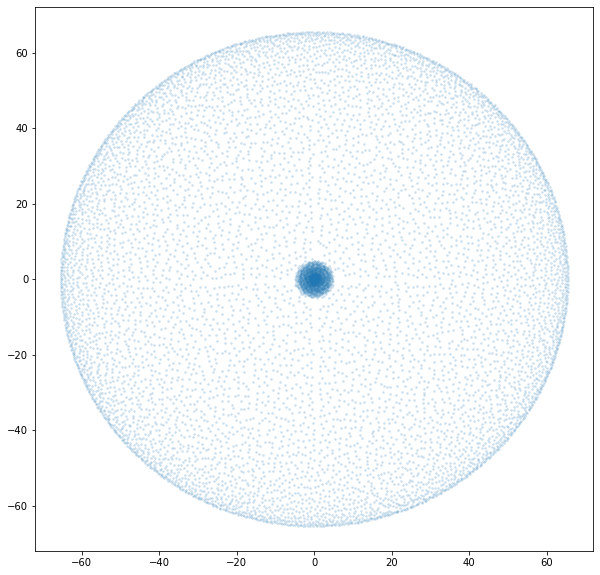

In [35]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
plt.scatter(embed[:, 0], embed[:, 1], s=3, alpha=.15)

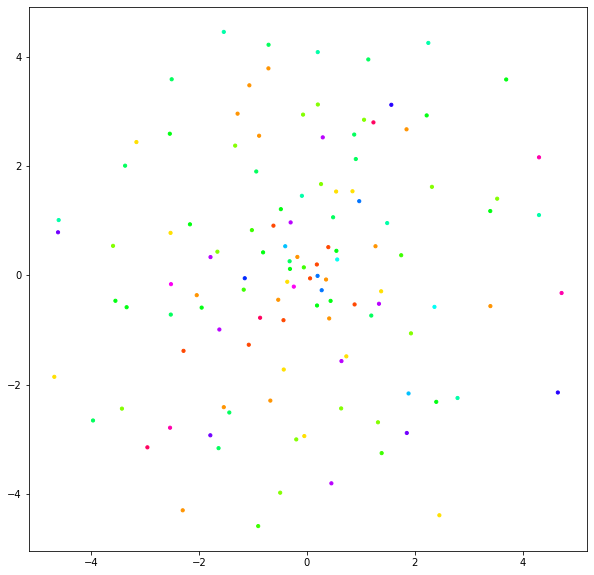

In [53]:
cmap = plt.get_cmap('hsv')
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
loc_embed = embed[flat_atlas > 0]

colors = cmap((loc_atlas - 1) / max(loc_atlas))
ax.scatter(loc_embed[:, 0], loc_embed[:, 1], c=colors, s=10, alpha=1)

[Text(0.5909090909090909, 0.875, 'high_sat_color - low_sat_color <= 0.281\ngini = 0.75\nsamples = 10212\nvalue = [2553.0, 2553.0, 2553.0, 2553.0]\nclass = V3/4 dorsal'),
 Text(0.36363636363636365, 0.625, 'antidaylight <= -0.581\ngini = 0.733\nsamples = 5986\nvalue = [1045.207, 2170.838, 2285.322, 2148.762]\nclass = V3/4 ventral'),
 Text(0.18181818181818182, 0.375, 'antidaylight <= -1.162\ngini = 0.677\nsamples = 2637\nvalue = [266.201, 1508.949, 1694.264, 779.272]\nclass = V3/4 ventral'),
 Text(0.09090909090909091, 0.125, 'gini = 0.54\nsamples = 812\nvalue = [53.077, 181.231, 776.731, 205.961]\nclass = V3/4 ventral'),
 Text(0.2727272727272727, 0.125, 'gini = 0.676\nsamples = 1825\nvalue = [213.124, 1327.718, 917.533, 573.311]\nclass = MT/V3a'),
 Text(0.5454545454545454, 0.375, 'high_freq_lms - low_freq_lms <= 1.102\ngini = 0.717\nsamples = 3349\nvalue = [779.006, 661.889, 591.058, 1369.49]\nclass = V3/4 dorsal'),
 Text(0.45454545454545453, 0.125, 'gini = 0.712\nsamples = 2943\nvalue = 

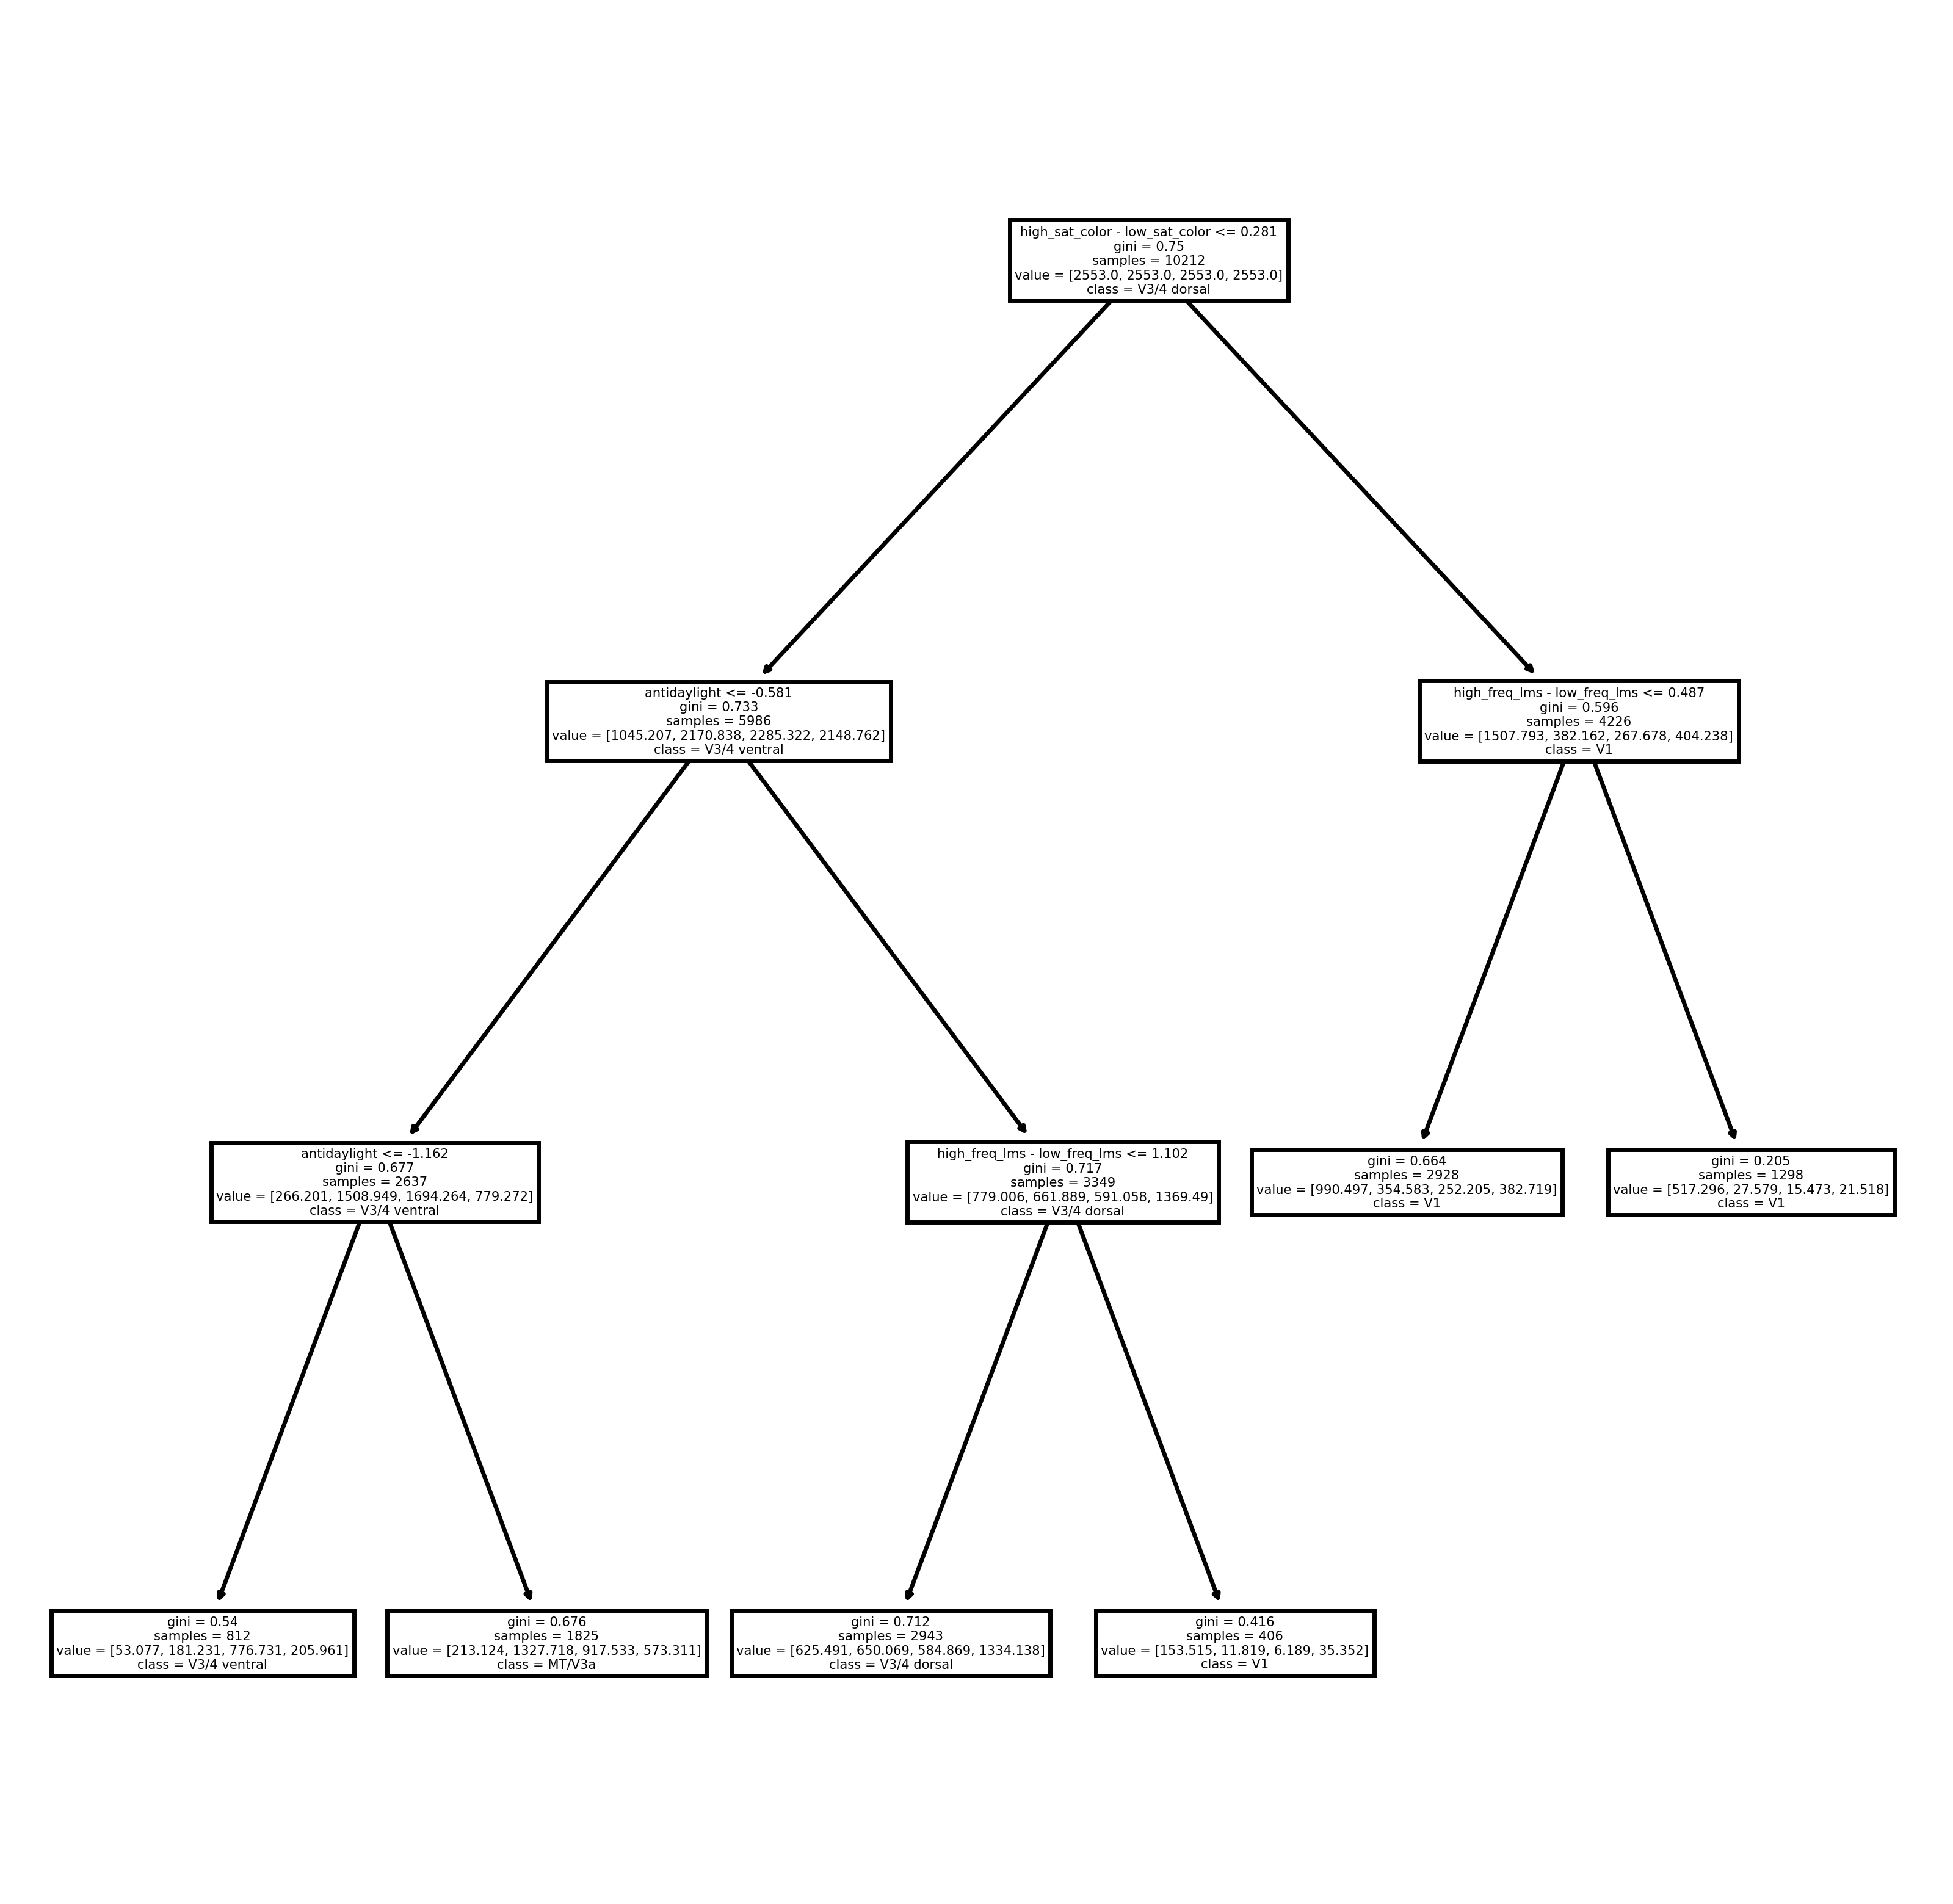

In [42]:
%matplotlib inline
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 8)
fig.set_dpi(500)
labels = np.zeros(len(flat_atlas))
labels[flat_atlas == 2] = 1
labels[flat_atlas == 3] = 1
labels[flat_atlas == 4] = 1
labels[flat_atlas == 6] = 1
labels[flat_atlas == 1] = 2
labels[flat_atlas == 1] = 2
labels[flat_atlas == 11] = 2
labels[flat_atlas == 12] = 2
labels[flat_atlas == 15] = 3
labels[flat_atlas == 16] = 3
labels[flat_atlas == 19] = 3
labels[flat_atlas == 20] = 3
labels[flat_atlas == 13] = 4
labels[flat_atlas == 14] = 4
labels[flat_atlas == 17] = 4
labels[flat_atlas == 18] = 4
these_beta = flat_beta[labels > 0]
labels = labels[labels > 0]
dct = DecisionTreeClassifier(max_depth=3, class_weight='balanced', criterion='gini', splitter='best', max_leaf_nodes=6)
dct.fit(these_beta, labels)
plot_tree(dct, ax=ax, feature_names=feature_names, class_names=['V1', 'MT/V3a', 'V3/4 ventral', 'V3/4 dorsal'])

In [30]:
yhat = np.array(dct.predict(these_beta))
correct = (yhat == labels)
acc = np.count_nonzero(correct) / len(labels)
print(acc)

0.5561104582843713
